In [1]:
!pip install tensorflow numpy matplotlib scikit-learn pandas kaggle --quiet


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dadulrishan","key":"779b6b4722ecb849b78e947efdbe85c2"}'}

In [4]:
# Make the .kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 81% 49.0M/60.3M [00:00<00:00, 242MB/s]
100% 60.3M/60.3M [00:00<00:00, 258MB/s]


In [6]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [7]:
!ls

fer2013.zip  sample_data  test	train


In [8]:
# Verify dataset paths

import os
def check_dataset_paths(train_dir, test_dir):
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory {train_dir} not found.")
    if not os.path.exists(test_dir):
        raise FileNotFoundError(f"Test directory {test_dir} not found.")
    print("Dataset paths verified. Training and test directories exist.")

TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'

check_dataset_paths(TRAIN_DIR, TEST_DIR)

Dataset paths verified. Training and test directories exist.


In [9]:
#Create Data Generators
def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )

    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, valid_datagen, test_datagen

train_datagen, valid_datagen, test_datagen = create_data_generators()

In [10]:
import os

# Function to check if directories exist
def verify_directories(*dirs):
    for dir_path in dirs:
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory not found: {dir_path}")
        print(f"Directory exists: {dir_path}")

# Directories to verify
TRAIN_DIR = '/content/train'
TEST_DIR = '/content/test'

# Verify directories
verify_directories(TRAIN_DIR, TEST_DIR)

# Creating Data Sets
train_dataset = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

valid_dataset = valid_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical'
)


Directory exists: /content/train
Directory exists: /content/test
Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [11]:
def build_resnet50v2_model(input_shape=(48, 48, 3), num_classes=7):
    base_model = ResNet50V2(include_top=False, weights=None, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_resnet50v2_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 54, 54, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 24, 24, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 26, 26, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 12, 12, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 12, 12, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 12, 12, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 12, 12, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 14, 14, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 12, 12, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 12, 12, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,579,143 (89.95 MB)

 Trainable params: 23,533,703 (89.77 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [12]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

# Define F1 Score
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

# Metrics
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score
]


In [13]:


# Compile the model
model = build_resnet50v2_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=METRICS
)

In [14]:
# Callbacks
lrd = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
mcp = ModelCheckpoint('best_model_resnet50v2.keras', save_best_only=True, monitor='val_loss', mode='min')

callbacks = [lrd, es, mcp]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 131s 217ms/step - accuracy: 0.2039 - auc: 0.6031 - f1_score: 0.0459 - loss: 2.0574 - precision: 0.2182 - recall: 0.0260 - val_accuracy: 0.2594 - val_auc: 0.6562 - val_f1_score: 0.0000e+00 - val_loss: 1.8252 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 47s 127ms/step - accuracy: 0.2371 - auc: 0.6497 - f1_score: 0.0337 - loss: 1.9100 - precision: 0.2521 - recall: 0.0184 - val_accuracy: 0.2771 - val_auc: 0.6854 - val_f1_score: 0.0120 - val_loss: 1.8055 - val_precision: 0.2449 - val_recall: 0.0063 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 134ms/step - accuracy: 0.2711 - auc: 0.6730 - f1_score: 0.0418 - loss: 1.8502 - precision: 0.3449 - recall: 0.0227 - val_accuracy: 0.3181 - val_auc: 0.7126 - val_f1_score: 0.0642 - val_loss: 1.7452 - val_precision: 0.5155 - val_recall: 0.0347 - learning_rate: 1.0000e-04
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 44s 122ms/ste

In [15]:
#Test Accuracy
evaluation_results = model.evaluate(test_dataset, verbose=0)
test_loss = evaluation_results[0]
test_accuracy = evaluation_results[1]

print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.56


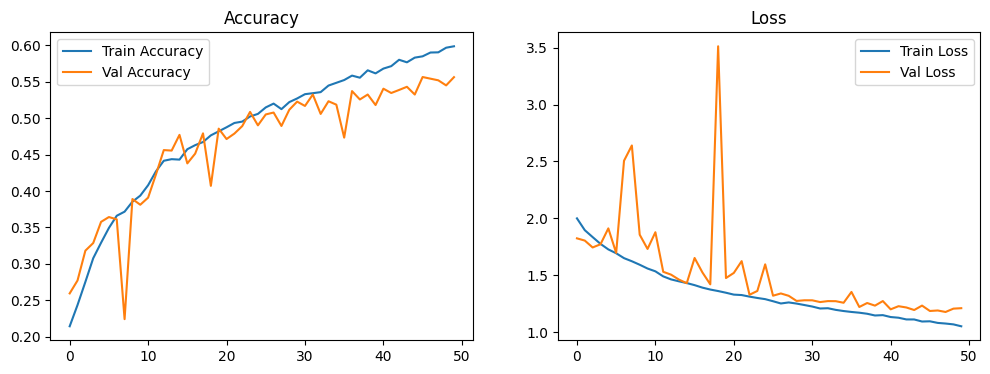

In [16]:
# Step 6: Visualize Results
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training_history(history)

In [17]:
# Save the final model
model.save('fer_resnet50v2_final.h5')